In [1]:
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches
from sklearn import linear_model
import numpy as np
import datetime

In [2]:
class trail:
    def __init__(self,nom_id,d,s,hd,csv):
        self.nom_id = nom_id
        self.date = d
        self.suivi = s
        self.heure_depart =hd
        self.csv_file =csv
        
    def remove_missing(self): # Elimine les empty cell et corrige s'il manque une heure de passage 
        if self.df_ppassage['Heure_Passage'].isnull().values.any():
            print('Il y a une heure de passage manquante',self.df_ppassage[self.df_ppassage['Heure_Passage'].isnull()]['Point_passage'])
            self.df_ppassage=self.df_ppassage.dropna(axis=0,subset=['Heure_Passage']).reset_index(drop=True)
            for i in range(1,len(self.df_ppassage)):             
                self.df_ppassage.loc[i,'Delta_Dist_km']=self.df_ppassage.loc[i,'Cumul_Dist_km']-self.df_ppassage.loc[i-1,'Cumul_Dist_km']
                self.df_ppassage.loc[i,'Delta_D+_m']=self.df_ppassage.loc[i,'Cumul_D+_m']-self.df_ppassage.loc[i-1,'Cumul_D+_m'] 
        
    def analyse2(self):  
        #
        reg = linear_model.LinearRegression(fit_intercept=False)
        y =np.array(self.df_ppassage['Delta_reel_h'])
        X1 = np.array(self.df_ppassage['Delta_Dist_km'])
        X2 = np.array(self.df_ppassage['Delta_D+_m'])
        # X3 = np.array(df_ppassage['H_reel_h'])
        X= np.stack((X1,X2)).T
        reg.fit(X,y)
        fig1=plt.figure()
        self.df_ppassage['Pred_T_Rom']=reg.predict(X)
        levels, categories = pd.factorize(self.df_ppassage['Trail'])
        colors = [plt.cm.tab10(i) for i in levels] # using the "tab10" colormap
        handles = [matplotlib.patches.Patch(color=plt.cm.tab10(i), label=c) for i, c in enumerate(categories)]
        plt.scatter(y,self.df_ppassage['Pred_T_Rom'],c=colors)
        plt.plot([0,np.max(y)],[0,np.max(y)])
        plt.grid()
        plt.xlabel('Durée segment reel (heure)')
        plt.ylabel('Durée segement predit (heure)')
        plt.legend(handles=handles,  title='Color')
        plt.show()
        print(reg.coef_)
        print('Regression score:',reg.score(X, y))
        self.vit_plat = round(1/reg.coef_[0],1)
        print('Vitesse sur le plat (en km/h) :',self.vit_plat)
        self.vit_Dplus = round(1/reg.coef_[1],1)
        print('Vitesse en dénivelé (en m/h) :',self.vit_Dplus)
        self.ralentissement = 0


    def analyse3(self):
        #
        reg = linear_model.LinearRegression(fit_intercept=False)
        y =np.array(self.df_ppassage['Delta_reel_h'])
        X1 = np.array(self.df_ppassage['Delta_Dist_km'])
        X2 = np.array(self.df_ppassage['Delta_D+_m'])
        X3 = np.array(self.df_ppassage['Cumul_Dist_km'])
        X= np.stack((X1,X2,X3)).T
        reg.fit(X,y)
        fig1=plt.figure()
        plt.scatter(y,reg.predict(X),c='blue')
        plt.plot([0,np.max(y)],[0,np.max(y)],c='red')
        plt.grid()
        plt.xlabel('Durée segment reel (heure)')
        plt.ylabel('Durée segement predit (heure)')
        plt.show()
        print(reg.coef_)
        print('Regression score:',reg.score(X, y))
        self.vit_plat = round(1/reg.coef_[0],1)
        print('Vitesse sur le plat (en km/h) :',self.vit_plat)
        self.vit_Dplus = round(1/reg.coef_[1],1)
        print('Vitesse en dénivelé (en m/h) :',self.vit_Dplus)
        self.ralentissement = round(reg.coef_[2],5)
        print('Ralentissement (en h ajouter /km) :',self.ralentissement)
        # return (vit_plat,vit_Dplus)
        
    def pred_temps(self, vit_plat,vit_Dplus,ralentissement,durée_stop,à_partir_de):
        print('Opti.: Vit_plat_km/h:',vit_plat,' | Vit_den+_m/h:', vit_Dplus,' | Ralent.:',ralentissement)
        df = self.df_ppassage
        df['Pred_Cum_T_Rom']=0 
        df['Pred_T_Rom']=0
        df['Pred_T_Rom']=round(df['Delta_Dist_km']/vit_plat+df['Delta_D+_m']/vit_Dplus+df['Cumul_Dist_km']*ralentissement,2)
        # df['Heure_predite']= 
        for i in range(1,len(df)):             
            df.loc[i,'Pred_Cum_T_Rom']=df.loc[i-1,'Pred_Cum_T_Rom']+df.loc[i,'Pred_T_Rom']
        for i in range(1,len(df)): 
            if df.loc[i,'Pred_Cum_T_Rom']>à_partir_de:
                df.loc[i,'Pred_Cum_T_Rom']=df.loc[i,'Pred_Cum_T_Rom']+durée_stop
            df.loc[i,'Heure_predite']=(pd.to_datetime(f'{self.date} {self.heure_depart}')+pd.Timedelta(hours=(df.loc[i,'Pred_Cum_T_Rom']//1), minutes= (df.loc[i,'Pred_Cum_T_Rom']%1*60))).strftime("%a. %H:%M")         
        return df

        

In [3]:
Lst_trails = pd.read_csv('ListeDesTrails.csv',sep=',')
Lst_trails

,Trail,Date,Suivi,Heure_depart,Lien_URL,Fichier_parcours_gpx,Vit_plat_km/h,Vit_den+_m/h,Csv_file,Date_dt
0,20195REFUGES,2019-07-28,livetrail,07:30:00,https://livetrail.net/histo/fiz_2019/coureur.php,NaN,10.0,1229.8,2019-07-28_5ref_31.7km.csv,2019-07-28
1,2019MCC,2019-08-26,livetrail,10:00:00,https://livetrail.net/histo/utmb_2019/coureur.php,tracedetrail_94254.gpx,6.9,2933.5,2019-08-26_MCC_39.1km.csv,2019-08-26
2,2020GTC,2020-09-13,livetrail,06:00:00,https://livetrail.net/histo/serreche_2020/cour...,NaN,7.0,1314.0,2020-09-13_GTC_56.5km.csv,2020-09-13
3,20218REFUGES,2021-07-25,livetrail,05:00:00,https://fiz.livetrail.net/coureur.php,tracedetrail_156428.gpx,8.4,1217.6,2021-07-25_Tour des 8 refuges Evadict_65.1km.csv,2021-07-25
4,2021DOOBLE,2021-07-31,livetrail,08:00:00,https://megevenaturetrail.livetrail.run/coureu...,NaN,13.5,1643.0,2021-07-31_LA DOOBLE - 16 KM_17.9km.csv,2021-07-31
5,2021TRAVNORD,2021-08-21,livetrail,05:15:00,https://echappeebelle.livetrail.run/parcours....,tracedetrail_135447.gpx,5.2,2137.3,2021-08-21_Traversée Nord_83.4km.csv,2021-08-21
6,2022UTHG,2022-06-17,livetrail,23:45:00,https://ultratrailduhautgiffre.livetrail.run/c...,tracedetrail_166975.gpx,6.0,1283.3,2022-06-17_Ultra-Trail® du haut-Giffre_97.4km.csv,2022-06-17
7,2022MBM,2022-06-25,livetrail,08:00:00,https://mbm.livetrail.run/coureur.php,23km-2022.gpx,14.3,882.0,2022-06-24_23km du Mont-Blanc_24.4km.csv,2022-06-25
8,2022UTB,2022-07-16,livetrack,04:00:00,https://www.livetrack.me/fr/evenement/ultratou...,ultra_tour_du_beaufortain_2022-13673263-165493...,5.4,1177.4,2022-07-16_Ultra Tour du Beaufortain 2022_114....,2022-07-16
9,2023UTLAC,2023-06-16,livetrail,19:00:00,https://ultratrailduhautgiffre.livetrail.run/c...,tracedetrail_189127.gpx,NaN,NaN,NaN,NaN


In [4]:
PIK = "trails.dat"
Trails_objects = []
with open(PIK, "rb") as f:
    while True:
        try:
            Trails_objects.append(pickle.load(f))
        except EOFError:
            break

In [5]:
for i,T in enumerate(Trails_objects):
    print(i,T.nom_id,T.date,T.suivi,T.heure_depart,T.csv_file)

0 20195REFUGES 2019-07-28 livetrail 07:30:00 2019-07-28_5ref_31.7km.csv
1 2019MCC 2019-08-26 livetrail 10:00:00 2019-08-26_MCC_39.1km.csv
2 2020GTC 2020-09-13 livetrail 06:00:00 2020-09-13_GTC_56.5km.csv
3 20218REFUGES 2021-07-25 livetrail 05:00:00 2021-07-25_Tour des 8 refuges Evadict_65.1km.csv
4 2021DOOBLE 2021-07-31 livetrail 08:00:00 2021-07-31_LA DOOBLE - 16 KM_17.9km.csv
5 2021TRAVNORD 2021-08-21 livetrail 05:15:00 2021-08-21_Traversée Nord_83.4km.csv
6 2022UTHG 2022-06-17 livetrail  23:45:00 2022-06-17_Ultra-Trail® du haut-Giffre_97.4km.csv
7 2022MBM 2022-06-25 livetrail 08:00:00 2022-06-24_23km du Mont-Blanc_24.4km.csv
8 2022UTB 2022-07-16 livetrack 04:00:00 2022-07-16_Ultra Tour du Beaufortain 2022_114.0km.csv
9 All 1979-12-05 NA NA NA


In [6]:
Trails_objects[8].df_ppassage[['Point_passage','Heure_Passage']]

,Point_passage,Heure_Passage
0,Départ,04:00:49
1,Gîte de Molliessoulaz,04:44:29
2,Les Chappes,05:21:02
3,Frêtte basse,06:09:26
4,Col des Lacs,06:53:42
5,Chalet du Soufflet,07:16:23
6,Ardoisière de Cevins,07:56:40
7,Col des Combettes,08:37:22
8,Col des Bonnets rouges,09:22:21
9,Lac de St Guerin,10:02:31


### Calcul des vitesse moyennes de chaque trail - Methode sans bound

0 20195REFUGES


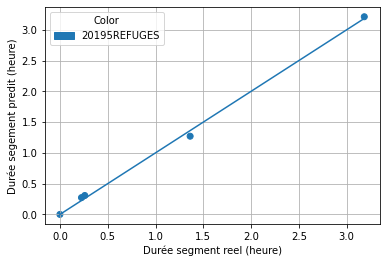

[0.09960428 0.00081312]
Regression score: 0.9980663937992169
Vitesse sur le plat (en km/h) : 10.0
Vitesse en dénivelé (en m/h) : 1229.8
-------------new_analysis_completed-------------
1 2019MCC


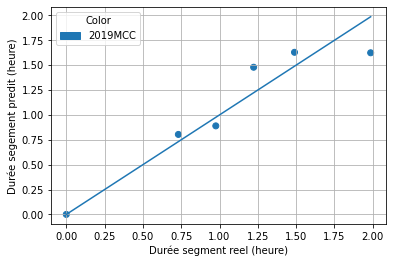

[0.14504338 0.00034089]
Regression score: 0.900777843426083
Vitesse sur le plat (en km/h) : 6.9
Vitesse en dénivelé (en m/h) : 2933.5
-------------new_analysis_completed-------------
2 2020GTC


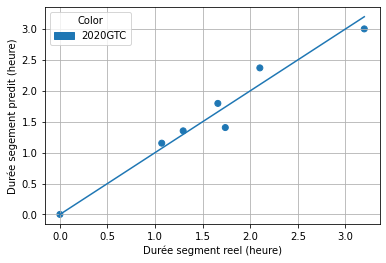

[0.14381419 0.00076103]
Regression score: 0.9564604652577346
Vitesse sur le plat (en km/h) : 7.0
Vitesse en dénivelé (en m/h) : 1314.0
-------------new_analysis_completed-------------
3 20218REFUGES


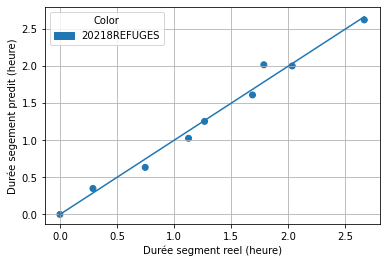

[0.118503   0.00082126]
Regression score: 0.9847593594156572
Vitesse sur le plat (en km/h) : 8.4
Vitesse en dénivelé (en m/h) : 1217.6
-------------new_analysis_completed-------------
4 2021DOOBLE


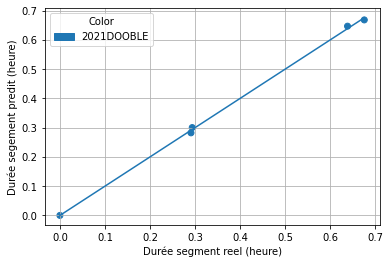

[0.07384874 0.00060865]
Regression score: 0.9992254882153258
Vitesse sur le plat (en km/h) : 13.5
Vitesse en dénivelé (en m/h) : 1643.0
-------------new_analysis_completed-------------
5 2021TRAVNORD


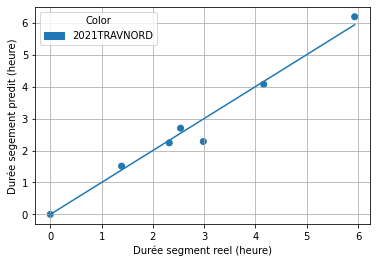

[0.19334829 0.00046788]
Regression score: 0.9720052202877091
Vitesse sur le plat (en km/h) : 5.2
Vitesse en dénivelé (en m/h) : 2137.3
-------------new_analysis_completed-------------
6 2022UTHG


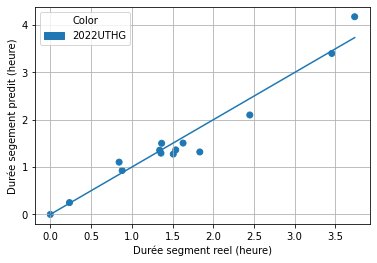

[0.16664985 0.00077923]
Regression score: 0.9462600828600893
Vitesse sur le plat (en km/h) : 6.0
Vitesse en dénivelé (en m/h) : 1283.3
-------------new_analysis_completed-------------
7 2022MBM


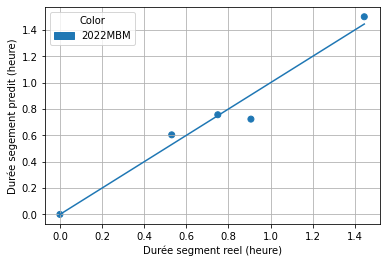

[0.06992796 0.00113374]
Regression score: 0.9621889169729566
Vitesse sur le plat (en km/h) : 14.3
Vitesse en dénivelé (en m/h) : 882.0
-------------new_analysis_completed-------------
8 2022UTB


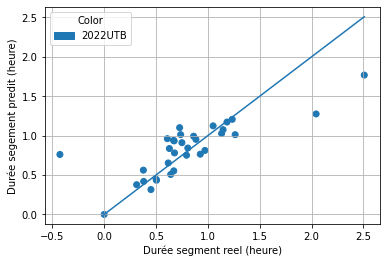

[0.1856038  0.00084932]
Regression score: 0.6084174081423477
Vitesse sur le plat (en km/h) : 5.4
Vitesse en dénivelé (en m/h) : 1177.4
-------------new_analysis_completed-------------
task_completed


In [26]:
Lst_trails['Date_dt']=pd.to_datetime(Lst_trails['Date'])
for i,l in Lst_trails.iterrows() :
    if l.Date_dt<=datetime.datetime.now() :# and pd.isnull(Lst_trails.loc[i,'Vit_plat_km/h']):
        print(i, Trails_objects[i].nom_id)
        # Trails_objects[i].load_ppassage_csv() # Trail déjà chargé à l'étape précédente
        Trails_objects[i].remove_missing() # Elimine les lignes manquantes et recalcule le temps
        Trails_objects[i].analyse2()
        # Chargement dans le fichier de synthese
        Lst_trails.loc[i,'Vit_plat_km/h'] = Trails_objects[i].vit_plat
        Lst_trails.loc[i,'Vit_den+_m/h'] = Trails_objects[i].vit_Dplus
        print('-------------new_analysis_completed-------------')
    Lst_trails.sort_values(by=['Date'],inplace=True)
    Lst_trails.to_csv('ListeDesTrails.csv',sep=',', index=False)
print('task_completed')

In [33]:
Trails_objects[8].df_ppassage

,id_x,Point_passage,Delta_Dist_km,Cumul_Dist_km,Delta_D+_m,Delta_D-_m,Cumul_D+_m,Cumul_D-_m,lon,lat,...,Temps_pause,Temps_course,H_reel_h,Delta_reel_h,H_reel_h_init,Delta_reel_h_init,Trail,Pred_T_Rom,Pred_Cum_T_Rom,Heure_predite
0,1,Départ,0.0,0.0,0,0,0,0,6.45826,45.71642,...,NaN,-,0.000000,0.000000,0.000000,0.000000,2022UTB,0.00,0.00,NaN
1,2,Gîte de Molliessoulaz,4.0,4.0,422,18,422,18,6.46178,45.70777,...,NaN,00:43:40,0.727778,0.727778,0.727778,0.727778,2022UTB,0.92,0.92,Sat. 04:55
2,3,Les Chappes,3.0,7.0,476,1,898,19,6.45347,45.69656,...,NaN,01:20:13,1.336944,0.609167,1.336944,0.609167,2022UTB,0.88,1.80,Sat. 05:48
3,4,Frêtte basse,2.0,9.0,555,7,1453,26,6.46982,45.68290,...,NaN,02:08:37,2.143611,0.806667,2.143611,0.806667,2022UTB,0.86,2.66,Sat. 06:39
4,5,Col des Lacs,4.0,13.0,318,113,1771,139,6.49444,45.66374,...,NaN,02:52:53,2.881389,0.737778,2.881389,0.737778,2022UTB,0.86,3.52,Sat. 07:31
5,6,Chalet du Soufflet,3.0,16.0,6,423,1777,562,6.51137,45.65223,...,(10 min),03:15:34,3.259444,0.378056,3.259444,0.378056,2022UTB,0.44,3.96,Sat. 07:57
6,7,Ardoisière de Cevins,2.0,18.0,214,63,1991,624,6.51010,45.63713,...,NaN,03:55:51,3.930833,0.671389,3.930833,0.671389,2022UTB,0.55,4.51,Sat. 08:30
7,8,Col des Combettes,3.0,21.0,263,108,2254,732,6.52981,45.64957,...,NaN,04:36:33,4.609167,0.678333,4.609167,0.678333,2022UTB,0.74,5.25,Sat. 09:15
8,9,Col des Bonnets rouges,4.0,25.0,198,286,2452,1019,6.56261,45.65310,...,NaN,05:21:32,5.358889,0.749722,5.358889,0.749722,2022UTB,0.80,6.05,Sat. 10:03
9,10,Lac de St Guerin,5.0,30.0,13,462,2465,1481,6.58220,45.64175,...,NaN,06:01:42,6.028333,0.669444,6.028333,0.669444,2022UTB,0.75,6.80,Sat. 10:48


In [27]:
Lst_trails

,Trail,Date,Suivi,Heure_depart,Lien_URL,Fichier_parcours_gpx,Vit_plat_km/h,Vit_den+_m/h,Csv_file,Date_dt
0,20195REFUGES,2019-07-28,livetrail,07:30:00,https://livetrail.net/histo/fiz_2019/coureur.php,NaN,10.0,1229.8,2019-07-28_5ref_31.7km.csv,2019-07-28
1,2019MCC,2019-08-26,livetrail,10:00:00,https://livetrail.net/histo/utmb_2019/coureur.php,tracedetrail_94254.gpx,6.9,2933.5,2019-08-26_MCC_39.1km.csv,2019-08-26
2,2020GTC,2020-09-13,livetrail,06:00:00,https://livetrail.net/histo/serreche_2020/cour...,NaN,7.0,1314.0,2020-09-13_GTC_56.5km.csv,2020-09-13
3,20218REFUGES,2021-07-25,livetrail,05:00:00,https://fiz.livetrail.net/coureur.php,tracedetrail_156428.gpx,8.4,1217.6,2021-07-25_Tour des 8 refuges Evadict_65.1km.csv,2021-07-25
4,2021DOOBLE,2021-07-31,livetrail,08:00:00,https://megevenaturetrail.livetrail.run/coureu...,NaN,13.5,1643.0,2021-07-31_LA DOOBLE - 16 KM_17.9km.csv,2021-07-31
5,2021TRAVNORD,2021-08-21,livetrail,05:15:00,https://echappeebelle.livetrail.run/parcours....,tracedetrail_135447.gpx,5.2,2137.3,2021-08-21_Traversée Nord_83.4km.csv,2021-08-21
6,2022UTHG,2022-06-17,livetrail,23:45:00,https://ultratrailduhautgiffre.livetrail.run/c...,tracedetrail_166975.gpx,6.0,1283.3,2022-06-17_Ultra-Trail® du haut-Giffre_97.4km.csv,2022-06-17
7,2022MBM,2022-06-25,livetrail,08:00:00,https://mbm.livetrail.run/coureur.php,23km-2022.gpx,14.3,882.0,2022-06-24_23km du Mont-Blanc_24.4km.csv,2022-06-25
8,2022UTB,2022-07-16,livetrack,04:00:00,https://www.livetrack.me/fr/evenement/ultratou...,ultra_tour_du_beaufortain_2022-13673263-165493...,5.4,1177.4,2022-07-16_Ultra Tour du Beaufortain 2022_114....,2022-07-16


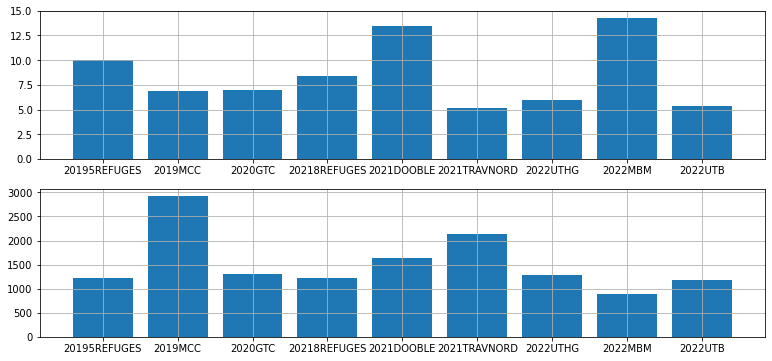

In [28]:
# figure, (ax1,ax2) = plt.subplots(2,figsize=(13,6))
plt.figure(figsize=(13,6))
plt.subplot(2,1,1)
plt.bar(Lst_trails['Trail'],Lst_trails['Vit_plat_km/h']);
plt.grid()
plt.subplot(2,1,2)
plt.bar(Lst_trails['Trail'],Lst_trails['Vit_den+_m/h']);
plt.grid()

# Analyse complète de tous les segments

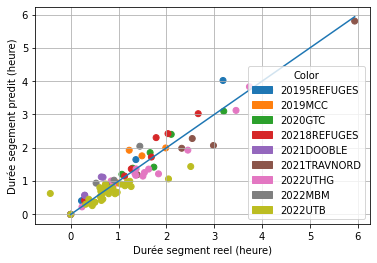

[0.15029442 0.0007408 ]
Regression score: 0.8973461006642428
Vitesse sur le plat (en km/h) : 6.7
Vitesse en dénivelé (en m/h) : 1349.9


In [29]:
# Analyse du trail en 2D
Trails_objects[-1].analyse2()

In [30]:
# Analyse en 3D
# Trails_objects[-1].analyse3()

# Live Trail prediction

In [31]:
print(len(Trails_objects))

10


Opti.: Vit_plat_km/h: 7  | Vit_den+_m/h: 1278  | Ralent.: 0
Opti.: Vit_plat_km/h: 10.0  | Vit_den+_m/h: 1229.8  | Ralent.: 0
Opti.: Vit_plat_km/h: 8.8  | Vit_den+_m/h: 949  | Ralent.: 0.00559
Opti.: Vit_plat_km/h: 7  | Vit_den+_m/h: 1278  | Ralent.: 0
Opti.: Vit_plat_km/h: 6.9  | Vit_den+_m/h: 2933.5  | Ralent.: 0
Opti.: Vit_plat_km/h: 8.8  | Vit_den+_m/h: 949  | Ralent.: 0.00559
Opti.: Vit_plat_km/h: 7  | Vit_den+_m/h: 1278  | Ralent.: 0
Opti.: Vit_plat_km/h: 7.0  | Vit_den+_m/h: 1314.0  | Ralent.: 0
Opti.: Vit_plat_km/h: 8.8  | Vit_den+_m/h: 949  | Ralent.: 0.00559
Opti.: Vit_plat_km/h: 7  | Vit_den+_m/h: 1278  | Ralent.: 0
Opti.: Vit_plat_km/h: 8.4  | Vit_den+_m/h: 1217.6  | Ralent.: 0
Opti.: Vit_plat_km/h: 8.8  | Vit_den+_m/h: 949  | Ralent.: 0.00559
Opti.: Vit_plat_km/h: 7  | Vit_den+_m/h: 1278  | Ralent.: 0
Opti.: Vit_plat_km/h: 13.5  | Vit_den+_m/h: 1643.0  | Ralent.: 0
Opti.: Vit_plat_km/h: 8.8  | Vit_den+_m/h: 949  | Ralent.: 0.00559
Opti.: Vit_plat_km/h: 7  | Vit_den+_m/h: 12

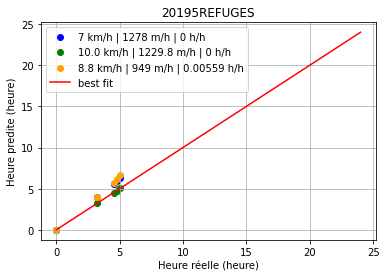

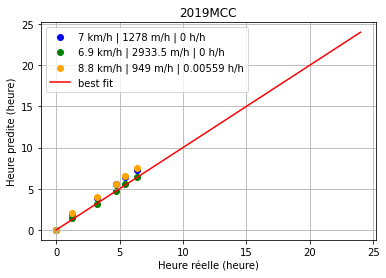

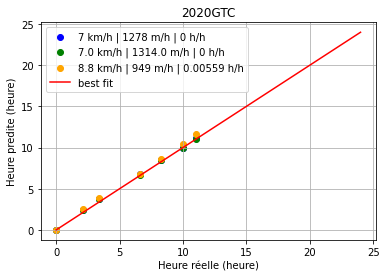

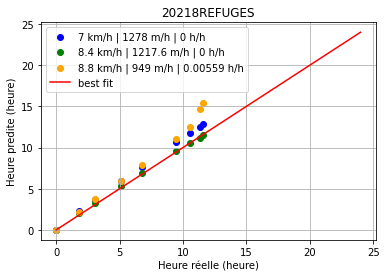

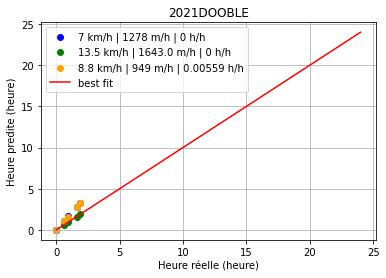

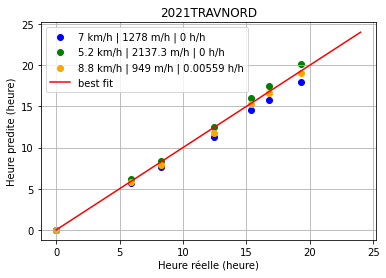

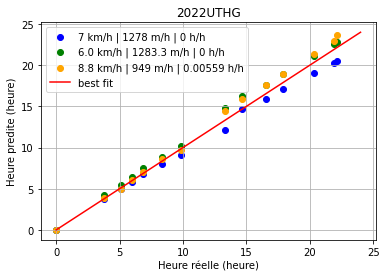

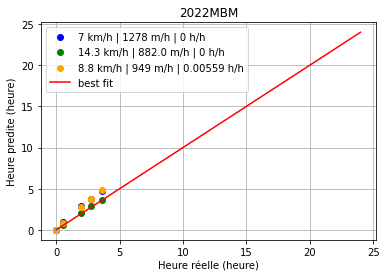

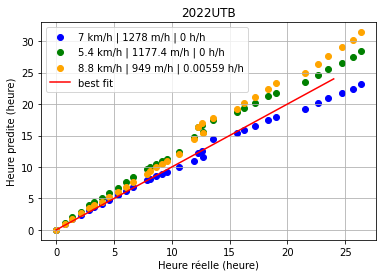

In [32]:
durée_arret = 1.25
à_partir_de = 13

for i,T in enumerate(Trails_objects):
    if pd.to_datetime(T.date)<=datetime.datetime.now() and i<(len(Trails_objects)-1):
        # print(T.nom_id,T.date,T.suivi,T.heure_depart,T.csv_file)
        fig2=plt.figure()
        #
        v11,v12,r1 = 7,1278,0
        df1 = T.pred_temps(v11,v12,r1,durée_arret,à_partir_de)
        plt.scatter(df1['H_reel_h'],df1['Pred_Cum_T_Rom'],color="blue")
        #
        v21,v22,r2 = Lst_trails.loc[i,'Vit_plat_km/h'],Lst_trails.loc[i,'Vit_den+_m/h'],0
        df2 = T.pred_temps(v21,v22,r2,durée_arret,à_partir_de)
        plt.scatter(df2['H_reel_h'],df2['Pred_Cum_T_Rom'],color="green")
        #
        v31,v32,r3 = 8.8,949, 0.00559
        df3 = T.pred_temps(v31,v32,r3,durée_arret,à_partir_de)
        plt.scatter(df3['H_reel_h'],df3['Pred_Cum_T_Rom'],color="orange")
        #
        #
        plt.plot([0,24],[0,24],c='red')
        plt.title(T.nom_id)
        plt.legend([f'{v11} km/h | {v12} m/h | {r1} h/h',f'{v21} km/h | {v22} m/h | {r2} h/h',f'{v31} km/h | {v32} m/h | {r3} h/h','best fit'])
        plt.xlabel('Heure réelle (heure)')
        plt.ylabel('Heure predite (heure)')
        plt.grid()

In [14]:
Trails_objects[6].df_ppassage[['Trail','Point_passage','Heure_Passage','Temps_course','H_reel_h_init','H_reel_h','Delta_reel_h_init','Delta_reel_h','Pred_T_Rom','Pred_Cum_T_Rom','Heure_predite']]

,Trail,Point_passage,Heure_Passage,Temps_course,H_reel_h_init,H_reel_h,Delta_reel_h_init,Delta_reel_h,Pred_T_Rom,Pred_Cum_T_Rom,Heure_predite
0,2022UTHG,Départ Samoëns,Ve. 23:45,00:00:00,0.000000,0.000000,0.000000,0.000000,0.00,0.00,NaN
1,2022UTHG,Pointe d'Angolon,Sa. 03:29,03:44:07,3.735278,3.735278,3.735278,3.735278,3.88,3.88,Sat. 03:37
2,2022UTHG,Mines d'Or,Sa. 04:51,05:05:37,5.093611,5.093611,1.358333,1.358333,1.09,4.97,Sat. 04:43
3,2022UTHG,Col de Coux,Sa. 05:44,05:58:33,5.975833,5.975833,0.882222,0.882222,1.06,6.03,Sat. 05:46
4,2022UTHG,Col de la Golèse,Sa. 06:34,06:49:13,6.820278,6.820278,0.844444,0.844444,1.06,7.09,Sat. 06:50
5,2022UTHG,Col de Bostan,Sa. 08:07,08:21:36,8.360000,8.360000,1.539722,1.539722,1.51,8.60,Sat. 08:21
6,2022UTHG,Le Crêt,Sa. 09:37,09:52:09,9.869167,9.869167,1.509167,1.509167,1.13,9.73,Sat. 09:28
7,2022UTHG,Boret,Sa. 14:20,14:34:27,14.574167,13.324167,4.705000,3.455000,3.41,14.39,Sat. 14:08
8,2022UTHG,Pelly,Sa. 15:42,15:56:26,15.940556,14.690556,1.366389,1.366389,1.54,15.93,Sat. 15:40
9,2022UTHG,Praz Commune,Sa. 17:32,17:46:32,17.775556,16.525556,1.835000,1.835000,1.68,17.61,Sat. 17:21


# Save Trails in pickle file

In [15]:
PIK = "trails.dat"
with open(PIK, "wb") as f:
    for T in Trails_objects:
        pickle.dump(T, f)

In [16]:
Lst_trails

,Trail,Date,Suivi,Heure_depart,Lien_URL,Fichier_parcours_gpx,Vit_plat_km/h,Vit_den+_m/h,Csv_file,Date_dt
0,20195REFUGES,2019-07-28,livetrail,07:30:00,https://livetrail.net/histo/fiz_2019/coureur.php,NaN,10.0,1229.8,2019-07-28_5ref_31.7km.csv,2019-07-28
1,2019MCC,2019-08-26,livetrail,10:00:00,https://livetrail.net/histo/utmb_2019/coureur.php,tracedetrail_94254.gpx,6.9,2933.5,2019-08-26_MCC_39.1km.csv,2019-08-26
2,2020GTC,2020-09-13,livetrail,06:00:00,https://livetrail.net/histo/serreche_2020/cour...,NaN,7.0,1314.0,2020-09-13_GTC_56.5km.csv,2020-09-13
3,20218REFUGES,2021-07-25,livetrail,05:00:00,https://fiz.livetrail.net/coureur.php,tracedetrail_156428.gpx,8.4,1217.6,2021-07-25_Tour des 8 refuges Evadict_65.1km.csv,2021-07-25
4,2021DOOBLE,2021-07-31,livetrail,08:00:00,https://megevenaturetrail.livetrail.run/coureu...,NaN,13.5,1643.0,2021-07-31_LA DOOBLE - 16 KM_17.9km.csv,2021-07-31
5,2021TRAVNORD,2021-08-21,livetrail,05:15:00,https://echappeebelle.livetrail.run/parcours....,tracedetrail_135447.gpx,5.2,2137.3,2021-08-21_Traversée Nord_83.4km.csv,2021-08-21
6,2022UTHG,2022-06-17,livetrail,23:45:00,https://ultratrailduhautgiffre.livetrail.run/c...,tracedetrail_166975.gpx,6.0,1283.3,2022-06-17_Ultra-Trail® du haut-Giffre_97.4km.csv,2022-06-17
7,2022MBM,2022-06-25,livetrail,08:00:00,https://mbm.livetrail.run/coureur.php,23km-2022.gpx,11.1,767.8,2022-06-24_23km du Mont-Blanc_24.4km.csv,2022-06-25
8,2022UTB,2022-07-16,livetrack,04:00:00,https://www.livetrack.me/fr/evenement/ultratou...,ultra_tour_du_beaufortain_2022-13673263-165493...,NaN,NaN,2022-07-16_Ultra Tour du Beaufortain 2022 Solo...,2022-07-16


# Plot Isolines

In [17]:
Lst_trails['Vit_plat_km/h']

0    10.0
1     6.9
2     7.0
3     8.4
4    13.5
5     5.2
6     6.0
7    11.1
8     NaN
Name: Vit_plat_km/h, dtype: float64

In [18]:
# v11,v12 = 7.0,1109
v11 = np.linspace(4.5, 16, 100,endpoint=False)#[4.5+i/10 for i in range(1,75,1)]
v12=np.linspace(500, 3000, 100,endpoint=False)#[700+i*20 for i in range(1,75,1)]
X, Y = np.meshgrid(v11, v12)
dist = 114
dplus = 7200
t = dist/X+dplus/Y

In [19]:
T_real = [dist/v1+dplus/v2 for v1,v2 in zip(Lst_trails['Vit_plat_km/h'].dropna(),Lst_trails['Vit_den+_m/h'].dropna())  ]

In [20]:
label = [f'{n} \n {round(t_real,1)}h' for n,t_real in zip(Lst_trails['Trail'],T_real)]

Text(7, 1109, 'All \n 22.8h')

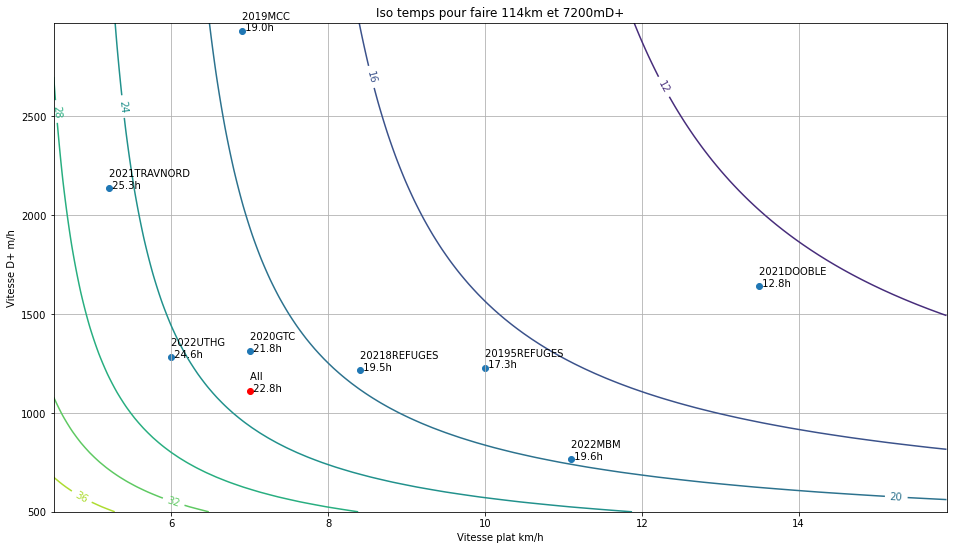

In [21]:
fig, ax = plt.subplots(figsize=(16,9))
# levels =[1+i/4 for i in range(0,9)]
Temps = ax.contour(X, Y, t)
ax.clabel(Temps, inline=True, fontsize=10)
ax.grid()
ax.set_title(f'Iso temps pour faire {dist}km et {dplus}mD+')
ax.set_xlabel('Vitesse plat km/h')
ax.set_ylabel('Vitesse D+ m/h')
ax.scatter(Lst_trails['Vit_plat_km/h'],Lst_trails['Vit_den+_m/h'])

for x,y,s in zip(Lst_trails['Vit_plat_km/h'],Lst_trails['Vit_den+_m/h'],label):
    ax.text(x,y,s)
ax.scatter([7],[1109],c='red')
ax.text(7,1109,f'All \n {round(dist/7+dplus/1109,1)}h')
# T_real.sort()
# Temps2 = ax.contour(X, Y, t,levels= T_real,linestyles='dashed')
# ax.clabel(Temps2, inline=True, levels = T_real, fontsize=10 )

In [26]:
# Constant vitesse D+
cstY = 1300
print(f'{cstY=}',f'{dist=}',f'{dplus=}')
t_real= np.array(T_real)
# t = dist/X+dplus/Y
cstX= dist/(t_real- dplus/cstY)
cstX
csty = [cstY for x in cstX]

cstY=1300 dist=114 dplus=7200


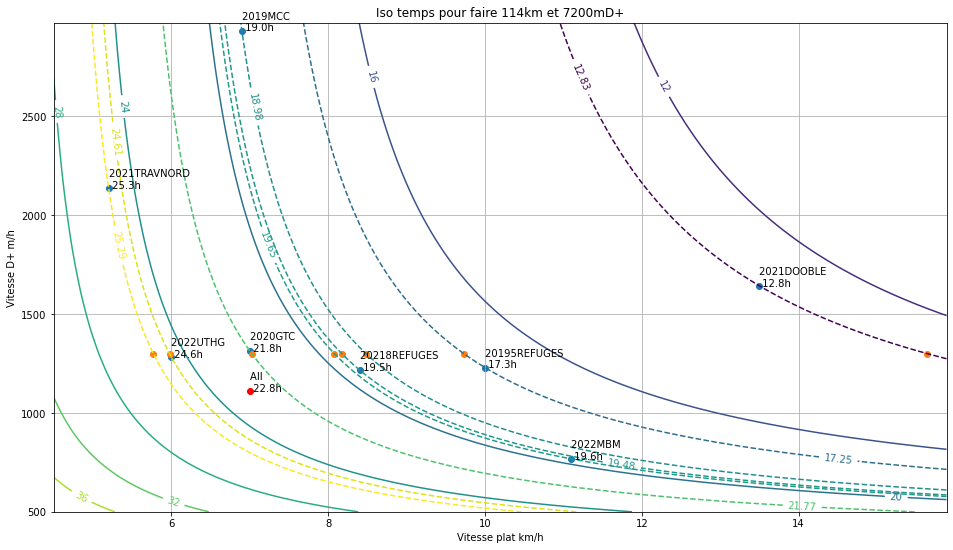

In [27]:
fig, ax = plt.subplots(figsize=(16,9))
# levels =[1+i/4 for i in range(0,9)]
Temps = ax.contour(X, Y, t)
ax.clabel(Temps, inline=True, fontsize=10)
ax.grid()
ax.set_title(f'Iso temps pour faire {dist}km et {dplus}mD+')
ax.set_xlabel('Vitesse plat km/h')
ax.set_ylabel('Vitesse D+ m/h')
ax.scatter(Lst_trails['Vit_plat_km/h'],Lst_trails['Vit_den+_m/h'])

for x,y,s in zip(Lst_trails['Vit_plat_km/h'],Lst_trails['Vit_den+_m/h'],label):
    ax.text(x,y,s)
ax.scatter([7],[1109],c='red')
ax.text(7,1109,f'All \n {round(dist/7+dplus/1109,1)}h')
Temps2 = ax.contour(X, Y, t,levels= sorted(T_real),linestyles='dashed')
ax.clabel(Temps2, inline=True, levels = sorted(T_real), fontsize=10 )
ax.scatter(cstX,csty)
fig.savefig('Iso-Temps UTB.jpg')

In [28]:
cstX

array([ 9.73015966,  8.48360502,  7.02545596,  8.17424681, 15.64169962,
        5.77117251,  5.97732586,  8.07980536])

In [25]:
T_real

[17.254610505773297,
 18.97614513009389,
 21.765166340508806,
 19.484700581941055,
 12.826672076824238,
 25.291813179100878,
 24.610535338580224,
 19.647712312468762]

### Segments pour lesquels on a un grand écart entre la prédiction et la réalité